In this notebook, we want to merge the t cell types until we get to a high classification accuracy. Then we will use this in this classification task when we do hyper-param tunning. The idea is that we would like to find a hyper-param that gives us a reasonable looking representation that has a good classification acc. Of course accuracy at the leaf-node level is probably to much to expect for example from M data. That is why we are going to merge the leaf nodes until we get to a level in which the accuracy is high enough and the number of types is not as much as the leaf nodes.

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cplAE_MET.utils.analysis_tree_helpers import HTree, get_merged_types

In [2]:
data_path = "/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/"
data_path = data_path + "MET_data_MPCs_with_mass_normalized_Mfeatures_12Dec22.mat"
data = sio.loadmat(data_path)

In [3]:
# 1d mask for t data
is_t_1d = np.any(~np.isnan(data['T_dat']), axis=1)

In [4]:
# rm empty space at the end of the cluster labels
data['cluster_label'] = np.array([i.rstrip() for i in data['cluster_label']])


# rm nans and find the unique cluster labels for all the data
ref_leaf = np.unique(data['cluster_label'][is_t_1d])
len(ref_leaf)

93

In [20]:
# check the labels on the taxonomy tree
tree_20180520 = pd.read_csv("/home/fahimehb/Local/new_codes/cplAE_MET/tree_20180520.csv")
tree_20180520_labels = tree_20180520[tree_20180520['leaf']==True]['label'].to_list()
tree_20180520_labels = np.array([i.rstrip() for i in tree_20180520_labels])
len(tree_20180520_labels)

133

In [19]:
tree_20180520_labels

['L2/3 IT VISp Rrad',
 'L2/3 IT VISp Adamts2',
 'L2/3 IT VISp Agmat',
 'L2/3 IT ALM Sla',
 'L2/3 IT ALM Ptrf',
 'L2/3 IT ALM Macc1 Lrg1',
 'L4 IT VISp Rspo1',
 'L5 IT VISp Hsd11b1 Endou',
 'L5 IT VISp Whrn Tox2',
 'L5 IT VISp Batf3',
 'L5 IT VISp Col6a1 Fezf2',
 'L5 IT VISp Col27a1',
 'L5 IT ALM Npw',
 'L5 IT ALM Pld5',
 'L5 IT ALM Cbln4 Fezf2',
 'L5 IT ALM Lypd1 Gpr88',
 'L5 IT ALM Tnc',
 'L5 IT ALM Tmem163 Dmrtb1',
 'L5 IT ALM Tmem163 Arhgap25',
 'L5 IT ALM Cpa6 Gpr88',
 'L5 IT ALM Gkn1 Pcdh19',
 'L6 IT ALM Tgfb1',
 'L6 IT ALM Oprk1',
 'L6 IT VISp Penk Col27a1',
 'L6 IT VISp Penk Fst',
 'L6 IT VISp Col23a1 Adamts2',
 'L6 IT VISp Col18a1',
 'L6 IT VISp Car3',
 'L5 PT VISp Chrna6',
 'L5 PT VISp Lgr5',
 'L5 PT VISp C1ql2 Ptgfr',
 'L5 PT VISp C1ql2 Cdh13',
 'L5 PT VISp Krt80',
 'L5 PT ALM Slco2a1',
 'L5 PT ALM Npsr1',
 'L5 PT ALM Hpgd',
 'L5 NP VISp Trhr Cpne7',
 'L5 NP ALM Trhr Nefl',
 'L5 NP VISp Trhr Met',
 'L6 NP ALM Trh',
 'L6 CT Nxph2 Sla',
 'L6 CT ALM Cpa6',
 'L6 CT VISp Krt80 Sla

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


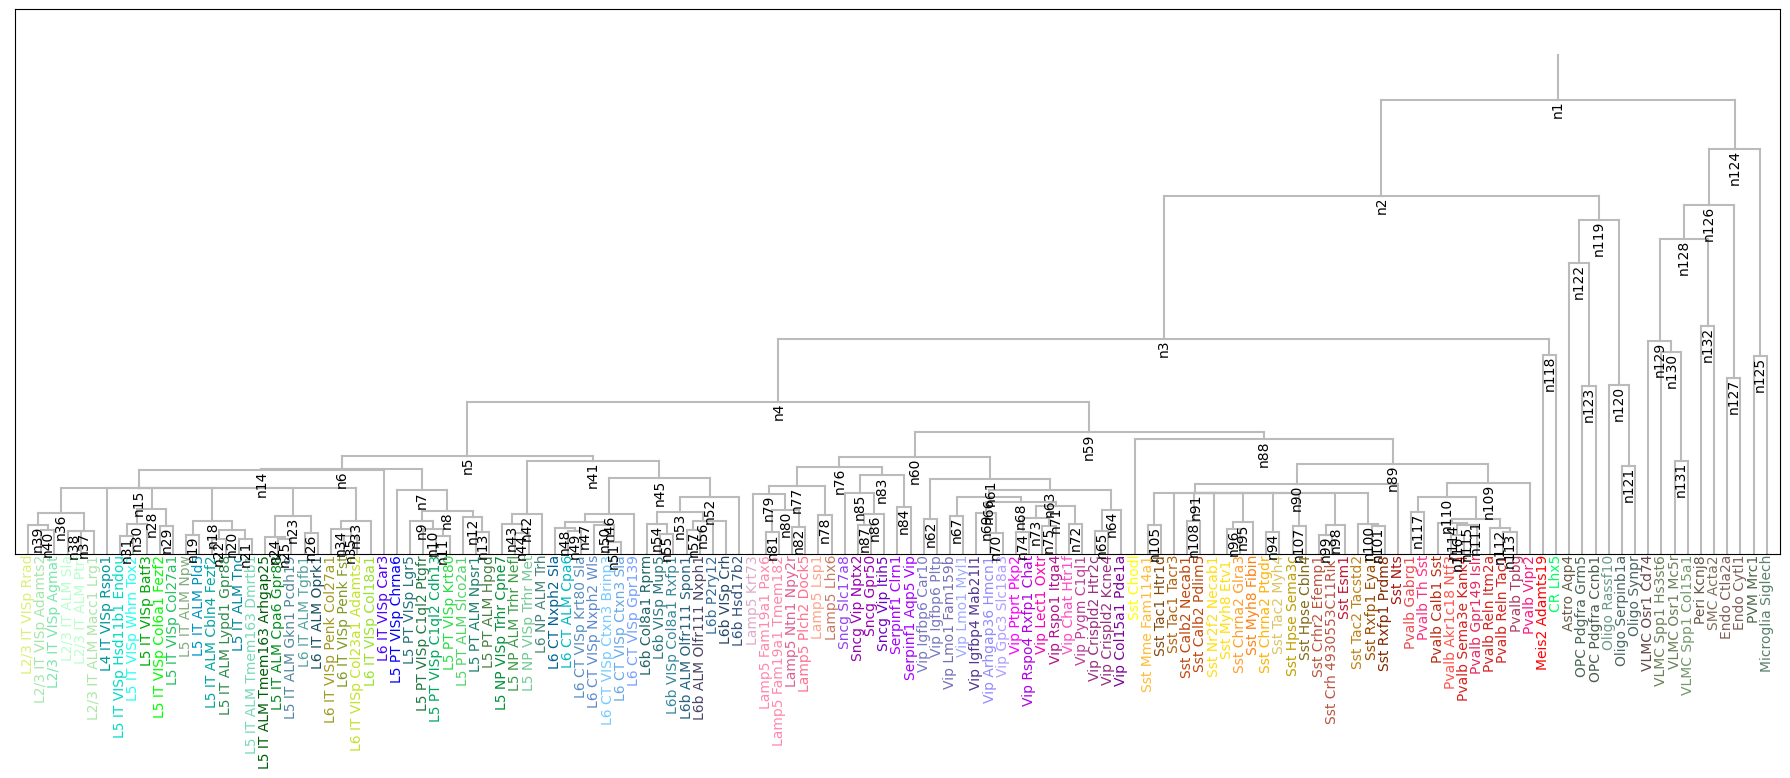

In [6]:
htree = HTree(htree_file="/home/fahimehb/Local/new_codes/cplAE_MET/tree_20180520.csv")
htree.plot(figsize=(18,7), fontsize=10)

In [8]:
#drop cells in small clusters
all_labels = data['cluster_label'][is_t_1d]
# drop_cluster=[]
# for cluster in np.unique(all_labels):
#     if np.sum(all_labels == cluster) < 10:
#         drop_cluster.append(cluster)

# is_not_small_cluster = [True if i not in drop_cluster else False for i in all_labels]
# X = data['T_dat'][is_t_1d][is_not_small_cluster]
# ref_labels = all_labels[is_not_small_cluster]

X = data['T_dat'][is_t_1d]
ref_labels = all_labels



In [10]:
t = []
acc = []
acc_std = []
for n_c in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    merged_types, mtree, _  = get_merged_types(htree_file="/home/fahimehb/Local/new_codes/cplAE_MET/tree_20180520.csv", 
                                        cells_labels=np.array(ref_labels), 
                                        num_classes=n_c, 
                                        ref_leaf=ref_leaf, 
                                        node="n1")
    # mtree.plot(figsize=(18,8), fontsize=10)
    print(len(Counter(merged_types)))
    t.append(len(Counter(merged_types)))

    labels = merged_types
    #apply pca on the X
    pca = PCA(100)
    PC = pca.fit_transform(X)

    # convert the t labels to numerics
    le = LabelEncoder()
    y = le.fit_transform(labels)
    
    accuracy = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(PC, y, test_size=0.2)
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))
    print("Accuracy:", np.mean(accuracy))
    acc.append(np.mean(accuracy))
    acc_std.append(np.std(accuracy))

93
Accuracy: 0.774731182795699
90
Accuracy: 0.783563748079877
86
Accuracy: 0.8038402457757297
81
Accuracy: 0.8073732718894009
79
Accuracy: 0.8175115207373272
74
Accuracy: 0.8311059907834102
69
Accuracy: 0.8466973886328726
64
Accuracy: 0.8513824884792627
59
Accuracy: 0.8714285714285713
54
Accuracy: 0.8835637480798771
50
Accuracy: 0.9006912442396313
47
Accuracy: 0.9113671274961599
44
Accuracy: 0.913978494623656


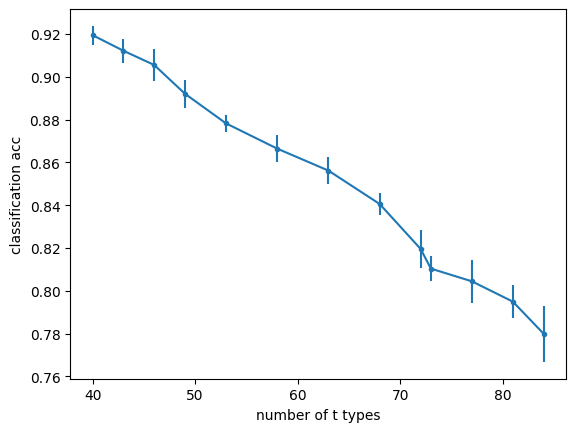

In [41]:
# When we remove the small clusters and then merge this is the results:
plt.errorbar(t, acc, acc_std, marker='.')
plt.xlabel("number of t types")
plt.ylabel("classification acc")
plt.show()

It seems that if we merge until we have 58 types the classification acc is around 86% which is already good enough. Now if we try to merge more, until we get to 90% accuracy, then we will end up with ~46 types. So we might want to try both these n-types in our optimization.

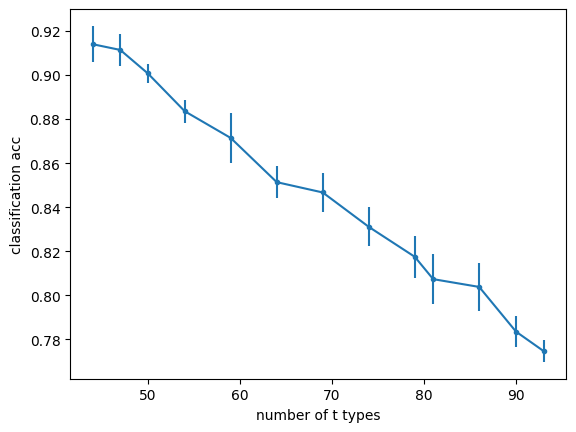

In [11]:
# When we dont remove the small clusters and only merge this is the results:
plt.errorbar(t, acc, acc_std, marker='.')
plt.xlabel("number of t types")
plt.ylabel("classification acc")
plt.show()

So from the onbe without any small cluster elimination I would take 40 and 50 merges which endsup in 59 and 50 types. with 88 and 90% classification acc